In [2]:
import nest_asyncio
import asyncio
from bs4 import BeautifulSoup
from playwright.async_api import async_playwright
import pandas as pd

first step:
爬到打席不超過200的大聯盟打者數據和其他打擊基本資料

In [17]:
nest_asyncio.apply()

async def fetch_data(url):
          
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)  # headless=False to see the browser
        page = await browser.new_page()
        await page.goto(url)
        
        # 等待目标元素出现
        await page.wait_for_selector('div#sortable_stats')
        
        # 获取页面内容
        content = await page.content()
        
        await browser.close()
        
        return content
        
url1= "https://baseballsavant.mlb.com/leaderboard/custom?year=2023%2C2022&type=batter&filter=&min=100&selections=player_age%2Cpa%2Chome_run%2Ck_percent%2Cbb_percent%2Cbatting_avg%2Cslg_percent%2Con_base_percent%2Cbabip%2Cwoba%2Cz_swing_percent%2Cz_swing_miss_percent%2Coz_swing_percent%2Coz_swing_miss_percent%2Coz_contact_percent%2Ciz_contact_percent&chart=false&x=player_age&y=player_age&r=no&chartType=beeswarm&sort=1&sortDir=desc"

# 使用 asyncio 执行异步函数
content22to23 = asyncio.get_event_loop().run_until_complete(fetch_data(url1))


# 解析 22HTML 内容
players_data = BeautifulSoup(content22to23, 'html.parser')
div_id_sortablestats = players_data.find('div', id='sortable_stats', class_='table-savant')

all_rows = []
headers = []

if div_id_sortablestats:
    # 在 div 中找到 thead
    thead = div_id_sortablestats.find('thead')

    if thead:
        # 提取表头，仅获取第一个文本节点
        headers = [th.contents[0].strip() if th.contents else '' for th in thead.find_all('th')]
        print("Headers:", headers)
    else:
        print("No thead found in div.")

    # 直接在 div 中找到 tbody
    tbody = div_id_sortablestats.find('tbody')

    if tbody:
        # 提取 tbody 中的所有行数据
        rows = tbody.find_all('tr')
        for row in rows:
            # 提取每行中的所有列数据
            cols = row.find_all('td')
            # 获取每个列中的文本，并去除空白字符
            cols_text = [col.get_text(strip=True) for col in cols]
            all_rows.append(cols_text)
    else:
        print("No tbody found in div.")
else:
    print("No div with id 'sortable_stats' and class 'table-savant' found.")

# 将所有行的数据转换为 DataFrame，并使用表头作为列名
data_22to23 = pd.DataFrame(all_rows, columns=headers)
data_22to23 

Headers: ['Rk.', 'Player', 'Year', 'Age', 'PA', 'HR', 'K%', 'BB%', 'AVG', 'SLG', 'OBP', 'BABIP', 'wOBA', 'Zone Swing %', 'Zone Swing & Miss %', 'Out of Zone Swing %', 'Out of Zone Swing & Miss%', 'Out of Zone Contact %', 'In Zone Contact %']


,Rk.,Player,Year,Age,PA,HR,K%,BB%,AVG,SLG,OBP,BABIP,wOBA,Zone Swing %,Zone Swing & Miss %,Out of Zone Swing %,Out of Zone Swing & Miss%,Out of Zone Contact %,In Zone Contact %
0,1,"Cabrera, Miguel",2023,40,370,4,20.0,8.4,.257,.353,.322,.317,.299,68.3,18.2,28.2,43.8,56.2,81.8
1,2,"Cruz Jr., Nelson",2023,42,152,5,30.3,3.9,.245,.399,.283,.323,.291,66.1,21.5,39.4,59.1,40.9,78.5
2,3,"Peralta, David",2023,35,422,7,17.1,4.7,.259,.381,.294,.296,.290,74.3,15.3,34.1,38.8,61.2,84.7
3,4,"Longoria, Evan",2023,37,237,11,30.8,9.7,.223,.422,.295,.277,.308,58.0,20.9,29.2,43.4,56.6,79.1
4,5,"Blackmon, Charlie",2023,36,413,8,13.3,9.4,.279,.440,.363,.307,.350,65.8,13.3,28.5,34.4,65.6,86.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,926,"Henderson, Gunnar",2022,21,132,4,25.8,12.1,.259,.440,.348,.333,.343,66.4,21.5,17.9,44.0,56.0,78.5
926,927,"Vaughn, Andrew",2022,24,555,17,17.3,5.6,.271,.429,.321,.301,.327,61.4,12.2,32.8,37.3,62.7,87.8
927,928,"Pasquantino, Vinnie",2022,24,298,10,11.4,11.7,.295,.450,.383,.306,.365,68.0,9.0,26.5,29.5,70.5,90.4
928,929,"Massey, Michael",2022,24,194,4,23.7,4.6,.243,.376,.307,.304,.302,73.5,22.3,35.6,39.1,59.4,75.4


In [21]:
#選出打席(PA)介於50~200者
# 將 'PA' 列轉換為數字類型
data_22to23['PA'] = pd.to_numeric(data_22to23['PA'], errors='coerce')

# 篩選出 'PA' 列值小於等於 200 的行
PA_mask = (data_22to23['PA'] <= 200)
new_data_22to23=data_22to23[PA_mask]
new_data_22to23=new_data_22to23.sort_values(by='K%',axis=0,ascending=False).reset_index(drop=True)

#存檔dataframe,用pd.read_pickle('data22_23_pa200.pkl')可讀取
new_data_22to23.to_pickle('data22_23_pa200.pkl')



new_data_22to23

,Rk.,Player,Year,Age,PA,HR,K%,BB%,AVG,SLG,OBP,BABIP,wOBA,Zone Swing %,Zone Swing & Miss %,Out of Zone Swing %,Out of Zone Swing & Miss%,Out of Zone Contact %,In Zone Contact %
0,667,"Heineman, Tyler",2022,31,174,0,9.8,4.6,.217,.268,.276,.243,.248,73.5,9.8,36.5,26.9,71.3,88.0
1,770,"Garcia, Dérmis",2022,24,125,5,44.0,6.4,.207,.388,.264,.339,.285,77.7,32.4,29.4,70.9,29.1,67.6
2,899,"Barrero, Jose",2022,24,174,2,43.7,5.2,.152,.206,.195,.264,.183,76.1,21.7,40.2,64.3,34.3,77.4
3,79,"Zunino, Mike",2023,32,140,3,43.6,10.7,.177,.306,.271,.317,.261,61.9,29.6,32.8,65.4,34.6,70.4
4,77,"Thompson, Trayce",2023,32,179,6,43.0,13.4,.163,.294,.285,.271,.266,62.4,33.2,20.4,70.1,29.9,66.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,170,"Trevino, Jose",2023,30,168,4,13.1,4.8,.210,.312,.257,.221,.252,55.1,10.1,37.3,24.6,75.4,89.2
208,339,"Campusano, Luis",2023,24,174,7,12.1,4.0,.319,.491,.356,.331,.364,74.0,14.0,35.5,26.9,73.1,86.0
209,684,"Meadows, Austin",2022,27,147,0,11.6,10.9,.250,.328,.347,.288,.307,62.8,8.5,21.1,26.2,73.8,91.5
210,161,"Reyes, Pablo",2023,29,185,2,11.4,7.6,.287,.377,.339,.315,.315,62.0,11.9,20.1,24.6,75.4,87.7


In [23]:
for col in new_data_22to23.columns[3:]:  
    new_data_22to23[col] = pd.to_numeric(new_data_22to23[col])
    #return new_data_22to23

new_data_22to23.iloc[:, 5:].describe()

,HR,K%,BB%,AVG,SLG,OBP,BABIP,wOBA,Zone Swing %,Zone Swing & Miss %,Out of Zone Swing %,Out of Zone Swing & Miss%,Out of Zone Contact %,In Zone Contact %
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,3.481132,26.180660,7.481132,0.218212,0.346821,0.285250,0.278821,0.279297,67.143868,19.325943,29.593396,46.543868,52.625943,80.077358
std,2.674192,6.652338,2.895269,0.040713,0.083569,0.044793,0.055107,0.046654,6.196223,5.488751,6.678135,11.870055,11.792713,5.393454
min,0.000000,9.800000,1.800000,0.124000,0.168000,0.154000,0.115000,0.145000,47.300000,7.600000,13.700000,21.700000,16.700000,63.300000
25%,2.000000,22.450000,5.500000,0.190750,0.288500,0.257750,0.243750,0.247750,63.500000,15.075000,25.175000,38.200000,43.700000,76.875000
50%,3.000000,25.700000,7.250000,0.218000,0.339000,0.283000,0.279500,0.277500,67.400000,19.050000,29.200000,44.650000,54.100000,80.500000
75%,5.000000,30.675000,9.400000,0.244250,0.393750,0.315000,0.318000,0.309250,71.300000,22.500000,33.650000,55.850000,60.600000,84.125000
max,17.000000,44.000000,15.200000,0.319000,0.727000,0.412000,0.410000,0.472000,81.100000,36.100000,48.800000,80.600000,78.300000,91.500000


In [24]:
for col in new_data_22to23.columns[3:]:  
    new_data_22to23[col] = pd.to_numeric(new_data_22to23[col])
new_data_22to23[['K%']].mean()

#篩選基本能力 K%
K_mask=new_data_22to23['K%']<30
new_data_22to23=new_data_22to23[K_mask]
new_data_22to23

,Rk.,Player,Year,Age,PA,HR,K%,BB%,AVG,SLG,OBP,BABIP,wOBA,Zone Swing %,Zone Swing & Miss %,Out of Zone Swing %,Out of Zone Swing & Miss%,Out of Zone Contact %,In Zone Contact %
0,667,"Heineman, Tyler",2022,31,174,0,9.8,4.6,0.217,0.268,0.276,0.243,0.248,73.5,9.8,36.5,26.9,71.3,88.0
64,115,"Choi, Ji Man",2023,32,117,6,29.9,8.5,0.163,0.385,0.239,0.169,0.267,71.8,21.0,23.5,57.8,42.2,79.0
65,692,"Delay, Jason",2022,27,167,1,29.9,5.4,0.213,0.271,0.265,0.308,0.243,74.6,23.4,31.4,52.6,47.4,75.9
66,743,"Adams, Riley",2022,26,155,5,29.7,7.7,0.176,0.310,0.245,0.220,0.249,58.7,18.5,34.0,47.7,51.4,81.5
67,618,"Garcia, Aramis",2022,29,115,1,29.6,2.6,0.213,0.259,0.248,0.301,0.228,73.2,22.6,31.1,50.0,48.6,77.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,170,"Trevino, Jose",2023,30,168,4,13.1,4.8,0.210,0.312,0.257,0.221,0.252,55.1,10.1,37.3,24.6,75.4,89.2
208,339,"Campusano, Luis",2023,24,174,7,12.1,4.0,0.319,0.491,0.356,0.331,0.364,74.0,14.0,35.5,26.9,73.1,86.0
209,684,"Meadows, Austin",2022,27,147,0,11.6,10.9,0.250,0.328,0.347,0.288,0.307,62.8,8.5,21.1,26.2,73.8,91.5
210,161,"Reyes, Pablo",2023,29,185,2,11.4,7.6,0.287,0.377,0.339,0.315,0.315,62.0,11.9,20.1,24.6,75.4,87.7


In [27]:
#篩選出本壘板紀律好的人(Plate discipline) 
#1.看好球帶內的揮棒以及擊中球。能在好球的情況下正確揮棒
pldp_mask = (
    (new_data_22to23['Zone Swing %'] > 67) | 
    (new_data_22to23['Zone Swing & Miss %'] <19)
) & (
    (new_data_22to23['Out of Zone Swing & Miss%'] < 30) & 
    (new_data_22to23['Out of Zone Contact %'] > 47) & 
    (new_data_22to23['In Zone Contact %'] > 53)
)

new_data_22to23=new_data_22to23[pldp_mask]

new_data_22to23.to_pickle('data22_23_final12.pkl') #存檔到data22_23_final12.pkl
new_data_22to23

,Rk.,Player,Year,Age,PA,HR,K%,BB%,AVG,SLG,OBP,BABIP,wOBA,Zone Swing %,Zone Swing & Miss %,Out of Zone Swing %,Out of Zone Swing & Miss%,Out of Zone Contact %,In Zone Contact %
0,667,"Heineman, Tyler",2022,31,174,0,9.8,4.6,0.217,0.268,0.276,0.243,0.248,73.5,9.8,36.5,26.9,71.3,88.0
139,197,"Mejía, Francisco",2023,27,160,5,23.8,3.8,0.227,0.400,0.258,0.266,0.280,71.2,16.7,48.8,29.5,69.9,83.3
183,62,"Narváez, Omar",2023,31,146,2,18.5,9.6,0.211,0.297,0.283,0.245,0.259,68.7,14.4,24.0,22.9,77.1,85.6
191,45,"Harrison, Josh",2023,35,114,2,17.5,2.6,0.204,0.291,0.263,0.229,0.248,67.7,20.4,30.9,25.9,72.2,78.9
205,810,"Lopez, Alejo",2022,26,156,1,13.5,5.8,0.262,0.331,0.314,0.301,0.286,72.4,11.2,29.2,28.6,71.4,88.8
208,339,"Campusano, Luis",2023,24,174,7,12.1,4.0,0.319,0.491,0.356,0.331,0.364,74.0,14.0,35.5,26.9,73.1,86.0


In [ ]:
#接著篩選長打能力


In [28]:
new_data_22to23[["Player"]]

,Player
0,"Heineman, Tyler"
139,"Mejía, Francisco"
183,"Narváez, Omar"
191,"Harrison, Josh"
205,"Lopez, Alejo"
208,"Campusano, Luis"


In [ ]:
second step:
找出中職打者投球中類並視覺化

In [9]:
nest_asyncio.apply()

async def scrape_season_teams_players(url, seasons, teams):
    data = []
    
    async with async_playwright() as p:
        # 启动浏览器
        browser = await p.chromium.launch(headless=False)
        # 创建新页面
        page = await browser.new_page()
        # 打开目标网址
        await page.goto(url)
        
        for season_value in seasons:
            print(f"Selecting season: {season_value}")
            # 选择年份
            await page.select_option('select[name="season"]', value=season_value)
            await page.wait_for_timeout(3000)  # 等待选项加载
            
            for team_value in teams:
                print(f"Selecting team: {team_value}")
                # 确保下拉选单可见并可操作
                await page.wait_for_selector('select[name="team"]')
                # 选择球队
                await page.select_option('select[name="team"]', value=team_value)
                await page.wait_for_timeout(3000)  # 等待选项加载
                
                # 获取球员选项
                await page.wait_for_selector('select[name="player"]')
                player_options = await page.query_selector_all('select[name="player"] option')
                
                for player_option in player_options:
                    player_value = await player_option.get_attribute('value')
                    player_name = await player_option.text_content()
                    
                    if player_value:  # 跳过默认选项
                        print(f"Selecting player: {player_name}")
                        # 选择球员
                        await page.select_option('select[name="player"]', value=player_value)
                        await page.wait_for_timeout(2000)  # 等待页面加载
                        
                        # 获取赛季、球队和球员的中文内容
                        season_text = await page.query_selector('select[name="season"] option:checked')
                        team_text = await page.query_selector('select[name="team"] option:checked')
                        season_text = await season_text.text_content()
                        team_text = await team_text.text_content()
                        
                        # 爬取球员的球种数据
                        pitch_data = await scrape_pitch_data(page, season_text, team_text, player_name)
                        
                        # 打印并存储数据
                        for pitch_type, pitch_count in pitch_data:
                            print(f"Season: {season_text}, Team: {team_text}, Player: {player_name}, Pitch Type: {pitch_type}, Count: {pitch_count}")
                            data.append([season_text, team_text, player_name, pitch_type, pitch_count])

        # 关闭浏览器
        await browser.close()

    # 转换为 DataFrame
    df = pd.DataFrame(data, columns=['Season', 'Team', 'Player', 'Pitch Type', 'Count'])

    # 将数据转换为每个玩家只出现一次的形式
    df_pivot = df.pivot_table(index=['Season', 'Team', 'Player'], columns='Pitch Type', values='Count', fill_value=0).reset_index()

    return df_pivot

async def scrape_pitch_data(page, season_text, team_text, player_name):
    # 等待包含投手数据的 <g> 元素加载
    await page.wait_for_selector('g[transform^="translate"]')
    
    data = []
    pitch_groups = await page.query_selector_all('g[transform^="translate"]')

    for group in pitch_groups:
        # 获取每个球种的圆圈和文本元素
        texts = await group.query_selector_all('text')
        
        for text in texts:
            pitch_text = await text.text_content()
            try:
                pitch_type, pitch_count = pitch_text.rsplit(maxsplit=1)
                pitch_count = int(pitch_count.strip())
                pitch_type = pitch_type.strip()
                data.append([pitch_type, pitch_count])
            except ValueError as e:
                print(f"Error processing text '{pitch_text}' for {season_text}, {team_text}, {player_name}: {e}")
    
    return data


url = 'https://www.rebas.tw/pitch-strategy'
seasons = ['CPBL-2024-xa', 'CPBL-2023-sk']
teams = ['中信兄弟']

df_elephant = asyncio.run(scrape_season_teams_players(url, seasons, teams))

# 打印 DataFrame
df_elephant

Selecting season: CPBL-2024-xa
Selecting team: 中信兄弟
Selecting player: 陳琥
Error processing text '0-0' for 中職2024年, 中信兄弟, 陳琥: not enough values to unpack (expected 2, got 1)
Error processing text '0-1' for 中職2024年, 中信兄弟, 陳琥: not enough values to unpack (expected 2, got 1)
Error processing text '1-0' for 中職2024年, 中信兄弟, 陳琥: not enough values to unpack (expected 2, got 1)
Error processing text '0-2' for 中職2024年, 中信兄弟, 陳琥: not enough values to unpack (expected 2, got 1)
Error processing text '1-1' for 中職2024年, 中信兄弟, 陳琥: not enough values to unpack (expected 2, got 1)
Error processing text '2-0' for 中職2024年, 中信兄弟, 陳琥: not enough values to unpack (expected 2, got 1)
Error processing text '1-2' for 中職2024年, 中信兄弟, 陳琥: not enough values to unpack (expected 2, got 1)
Error processing text '2-1' for 中職2024年, 中信兄弟, 陳琥: not enough values to unpack (expected 2, got 1)
Error processing text '3-0' for 中職2024年, 中信兄弟, 陳琥: not enough values to unpack (expected 2, got 1)
Error processing text '2-2' for 中職20

Pitch Type,Season,Team,Player,二/伸,卡特,四縫,小便,快指,指叉,曲球,滑球,蝴蝶,變速
0,中職2023年,中信兄弟,余謙,342.0,47.0,164.0,0.0,0.0,0.0,80.0,148.0,0.0,247.0
1,中職2023年,中信兄弟,吳俊偉,0.0,0.0,433.0,0.0,0.0,0.0,2.0,300.0,0.0,210.0
2,中職2023年,中信兄弟,吳哲源,0.0,0.0,280.0,0.0,0.0,0.0,49.0,96.0,0.0,139.0
3,中職2023年,中信兄弟,呂彥青,0.0,0.0,537.0,0.0,0.0,0.0,88.0,196.0,0.0,167.0
4,中職2023年,中信兄弟,官大元,3.0,0.0,50.0,0.0,0.0,7.0,13.0,27.0,0.0,9.0
5,中職2023年,中信兄弟,廖乙忠,0.0,0.0,134.0,0.0,0.0,14.0,15.0,45.0,0.0,0.0
6,中職2023年,中信兄弟,張祖恩,0.0,0.0,112.0,0.0,0.0,0.0,0.0,78.0,0.0,14.0
7,中職2023年,中信兄弟,彭識穎,0.0,0.0,100.0,0.0,0.0,0.0,29.0,87.0,0.0,19.0
8,中職2023年,中信兄弟,徐基麟,0.0,0.0,107.0,0.0,0.0,0.0,14.0,35.0,0.0,48.0
9,中職2023年,中信兄弟,德保拉,0.0,0.0,1473.0,0.0,0.0,0.0,753.0,0.0,0.0,473.0


In [10]:
url = 'https://www.rebas.tw/pitch-strategy'
seasons = ['CPBL-2024-xa']
teams = ['台鋼雄鷹']

df_hawk = asyncio.run(scrape_season_teams_players(url, seasons, teams))

# 打印 DataFrame
df_hawk

Selecting season: CPBL-2024-xa
Selecting team: 台鋼雄鷹
Selecting player: 賴鴻誠
Error processing text '0-0' for 中職2024年, 台鋼雄鷹, 賴鴻誠: not enough values to unpack (expected 2, got 1)
Error processing text '0-1' for 中職2024年, 台鋼雄鷹, 賴鴻誠: not enough values to unpack (expected 2, got 1)
Error processing text '1-0' for 中職2024年, 台鋼雄鷹, 賴鴻誠: not enough values to unpack (expected 2, got 1)
Error processing text '0-2' for 中職2024年, 台鋼雄鷹, 賴鴻誠: not enough values to unpack (expected 2, got 1)
Error processing text '1-1' for 中職2024年, 台鋼雄鷹, 賴鴻誠: not enough values to unpack (expected 2, got 1)
Error processing text '2-0' for 中職2024年, 台鋼雄鷹, 賴鴻誠: not enough values to unpack (expected 2, got 1)
Error processing text '1-2' for 中職2024年, 台鋼雄鷹, 賴鴻誠: not enough values to unpack (expected 2, got 1)
Error processing text '2-1' for 中職2024年, 台鋼雄鷹, 賴鴻誠: not enough values to unpack (expected 2, got 1)
Error processing text '3-0' for 中職2024年, 台鋼雄鷹, 賴鴻誠: not enough values to unpack (expected 2, got 1)
Error processing text '2-2

Pitch Type,Season,Team,Player,二/伸,卡特,四縫,快指,指叉,曲球,滑球,蝴蝶,變速
0,中職2024年,台鋼雄鷹,伍祐城,0.0,0.0,155.0,0.0,0.0,13.0,56.0,0.0,13.0
1,中職2024年,台鋼雄鷹,哈瑪星,0.0,56.0,542.0,1.0,42.0,67.0,50.0,0.0,43.0
2,中職2024年,台鋼雄鷹,小野寺賢人,2.0,18.0,386.0,0.0,66.0,118.0,129.0,0.0,6.0
3,中職2024年,台鋼雄鷹,巫柏葳,0.0,0.0,97.0,0.0,0.0,24.0,34.0,0.0,26.0
4,中職2024年,台鋼雄鷹,後勁,0.0,57.0,80.0,0.0,0.0,37.0,0.0,0.0,18.0
5,中職2024年,台鋼雄鷹,施子謙,9.0,0.0,230.0,0.0,80.0,103.0,70.0,0.0,35.0
6,中職2024年,台鋼雄鷹,曾品洋,0.0,0.0,40.0,0.0,2.0,1.0,8.0,0.0,0.0
7,中職2024年,台鋼雄鷹,林詩翔,0.0,0.0,109.0,0.0,0.0,0.0,23.0,0.0,78.0
8,中職2024年,台鋼雄鷹,楊達翔,0.0,0.0,286.0,0.0,38.0,74.0,0.0,0.0,0.0
9,中職2024年,台鋼雄鷹,江承諺,0.0,0.0,441.0,0.0,0.0,182.0,111.0,0.0,258.0


In [11]:
url = 'https://www.rebas.tw/pitch-strategy'
seasons = ['CPBL-2024-xa', 'CPBL-2023-sk']
teams = ['味全龍']

df_dragon = asyncio.run(scrape_season_teams_players(url, seasons, teams))

# 打印 DataFrame
df_dragon

Selecting season: CPBL-2024-xa
Selecting team: 味全龍
Selecting player: 吳俊杰
Error processing text '0-0' for 中職2024年, 味全龍, 吳俊杰: not enough values to unpack (expected 2, got 1)
Error processing text '0-1' for 中職2024年, 味全龍, 吳俊杰: not enough values to unpack (expected 2, got 1)
Error processing text '1-0' for 中職2024年, 味全龍, 吳俊杰: not enough values to unpack (expected 2, got 1)
Error processing text '0-2' for 中職2024年, 味全龍, 吳俊杰: not enough values to unpack (expected 2, got 1)
Error processing text '1-1' for 中職2024年, 味全龍, 吳俊杰: not enough values to unpack (expected 2, got 1)
Error processing text '2-0' for 中職2024年, 味全龍, 吳俊杰: not enough values to unpack (expected 2, got 1)
Error processing text '1-2' for 中職2024年, 味全龍, 吳俊杰: not enough values to unpack (expected 2, got 1)
Error processing text '2-1' for 中職2024年, 味全龍, 吳俊杰: not enough values to unpack (expected 2, got 1)
Error processing text '3-0' for 中職2024年, 味全龍, 吳俊杰: not enough values to unpack (expected 2, got 1)
Error processing text '2-2' for 中職20

Pitch Type,Season,Team,Player,二/伸,卡特,四縫,指叉,曲球,滑球,變速
0,中職2023年,味全龍,伍鐸,637.0,249.0,15.0,0.0,14.0,237.0,46.0
1,中職2023年,味全龍,劉家愷,0.0,0.0,12.0,0.0,4.0,2.0,0.0
2,中職2023年,味全龍,劉昱言,0.0,0.0,3.0,0.0,0.0,25.0,0.0
3,中職2023年,味全龍,吳俊杰,0.0,0.0,345.0,37.0,61.0,121.0,0.0
4,中職2023年,味全龍,吳君奕,0.0,0.0,34.0,0.0,0.0,13.0,8.0
5,中職2023年,味全龍,呂偉晟,31.0,0.0,0.0,0.0,18.0,0.0,6.0
6,中職2023年,味全龍,呂詠臻,0.0,0.0,472.0,33.0,204.0,0.0,1.0
7,中職2023年,味全龍,布里悍,982.0,0.0,41.0,0.0,309.0,456.0,195.0
8,中職2023年,味全龍,廖任磊,51.0,0.0,154.0,0.0,21.0,49.0,32.0
9,中職2023年,味全龍,張景淯,0.0,0.0,108.0,0.0,13.0,35.0,0.0


In [12]:
url = 'https://www.rebas.tw/pitch-strategy'
seasons = ['CPBL-2024-xa', 'CPBL-2023-sk']
teams = ['富邦悍將']

df_brave = asyncio.run(scrape_season_teams_players(url, seasons, teams))

# 打印 DataFrame
df_brave

Selecting season: CPBL-2024-xa
Selecting team: 富邦悍將
Selecting player: 布藍登
Error processing text '0-0' for 中職2024年, 富邦悍將, 布藍登: not enough values to unpack (expected 2, got 1)
Error processing text '0-1' for 中職2024年, 富邦悍將, 布藍登: not enough values to unpack (expected 2, got 1)
Error processing text '1-0' for 中職2024年, 富邦悍將, 布藍登: not enough values to unpack (expected 2, got 1)
Error processing text '0-2' for 中職2024年, 富邦悍將, 布藍登: not enough values to unpack (expected 2, got 1)
Error processing text '1-1' for 中職2024年, 富邦悍將, 布藍登: not enough values to unpack (expected 2, got 1)
Error processing text '2-0' for 中職2024年, 富邦悍將, 布藍登: not enough values to unpack (expected 2, got 1)
Error processing text '1-2' for 中職2024年, 富邦悍將, 布藍登: not enough values to unpack (expected 2, got 1)
Error processing text '2-1' for 中職2024年, 富邦悍將, 布藍登: not enough values to unpack (expected 2, got 1)
Error processing text '3-0' for 中職2024年, 富邦悍將, 布藍登: not enough values to unpack (expected 2, got 1)
Error processing text '2-2

Pitch Type,Season,Team,Player,二/伸,卡特,四縫,快指,指叉,曲球,滑球,蝴蝶,變速
0,中職2023年,富邦悍將,伍茲,33.0,0.0,104.0,0.0,0.0,36.0,27.0,0.0,8.0
1,中職2023年,富邦悍將,吳世豪,0.0,0.0,55.0,0.0,0.0,1.0,44.0,0.0,2.0
2,中職2023年,富邦悍將,安得勝,367.0,7.0,318.0,0.0,0.0,99.0,107.0,0.0,107.0
3,中職2023年,富邦悍將,富藍戈,0.0,0.0,595.0,0.0,0.0,0.0,193.0,0.0,177.0
4,中職2023年,富邦悍將,岳少華,0.0,0.0,399.0,0.0,0.0,36.0,169.0,0.0,153.0
5,中職2023年,富邦悍將,恩力\t,0.0,0.0,423.0,0.0,0.0,81.0,19.0,0.0,137.0
6,中職2023年,富邦悍將,曾峻岳,0.0,0.0,555.0,0.0,37.0,5.0,199.0,0.0,0.0
7,中職2023年,富邦悍將,李建勳,0.0,0.0,98.0,0.0,38.0,0.0,34.0,0.0,0.0
8,中職2023年,富邦悍將,李東洺,0.0,126.0,565.0,0.0,74.0,20.0,84.0,0.0,0.0
9,中職2023年,富邦悍將,歐書誠,0.0,0.0,198.0,0.0,0.0,25.0,77.0,0.0,104.0


In [13]:
url = 'https://www.rebas.tw/pitch-strategy'
seasons = ['CPBL-2024-xa', 'CPBL-2023-sk']
teams = ['樂天桃猿']

df_monkey = asyncio.run(scrape_season_teams_players(url, seasons, teams))

# 打印 DataFrame
df_monkey

Selecting season: CPBL-2024-xa
Selecting team: 樂天桃猿
Selecting player: 魔神樂
Error processing text '0-0' for 中職2024年, 樂天桃猿, 魔神樂: not enough values to unpack (expected 2, got 1)
Error processing text '0-1' for 中職2024年, 樂天桃猿, 魔神樂: not enough values to unpack (expected 2, got 1)
Error processing text '1-0' for 中職2024年, 樂天桃猿, 魔神樂: not enough values to unpack (expected 2, got 1)
Error processing text '0-2' for 中職2024年, 樂天桃猿, 魔神樂: not enough values to unpack (expected 2, got 1)
Error processing text '1-1' for 中職2024年, 樂天桃猿, 魔神樂: not enough values to unpack (expected 2, got 1)
Error processing text '2-0' for 中職2024年, 樂天桃猿, 魔神樂: not enough values to unpack (expected 2, got 1)
Error processing text '1-2' for 中職2024年, 樂天桃猿, 魔神樂: not enough values to unpack (expected 2, got 1)
Error processing text '2-1' for 中職2024年, 樂天桃猿, 魔神樂: not enough values to unpack (expected 2, got 1)
Error processing text '3-0' for 中職2024年, 樂天桃猿, 魔神樂: not enough values to unpack (expected 2, got 1)
Error processing text '2-2

Pitch Type,Season,Team,Player,二/伸,卡特,四縫,快指,指叉,曲球,滑球,蝴蝶,變速
0,中職2023年,樂天桃猿,威能帝,0.0,0.0,424.0,0.0,0.0,0.0,284.0,0.0,109.0
1,中職2023年,樂天桃猿,威達爾,0.0,193.0,454.0,0.0,0.0,127.0,247.0,0.0,171.0
2,中職2023年,樂天桃猿,張梓軒,0.0,0.0,21.0,0.0,0.0,13.0,24.0,0.0,0.0
3,中職2023年,樂天桃猿,後勁,108.0,356.0,265.0,0.0,0.0,101.0,0.0,0.0,140.0
4,中職2023年,樂天桃猿,曾仁和,0.0,375.0,497.0,0.0,0.0,332.0,0.0,0.0,313.0
5,中職2023年,樂天桃猿,曾家輝,0.0,0.0,16.0,0.0,0.0,0.0,3.0,0.0,0.0
6,中職2023年,樂天桃猿,朱承洋,0.0,0.0,300.0,0.0,30.0,0.0,144.0,0.0,0.0
7,中職2023年,樂天桃猿,林子崴,0.0,0.0,16.0,0.0,0.0,3.0,11.0,0.0,4.0
8,中職2023年,樂天桃猿,林華偉,0.0,1.0,10.0,0.0,0.0,0.0,6.0,0.0,1.0
9,中職2023年,樂天桃猿,楊彬,0.0,0.0,109.0,0.0,0.0,14.0,56.0,0.0,46.0


In [14]:
url = 'https://www.rebas.tw/pitch-strategy'
seasons = ['CPBL-2024-xa', 'CPBL-2023-sk']
teams = ['統一7-ELEVEn獅']

df_lion = asyncio.run(scrape_season_teams_players(url, seasons, teams))

# 打印 DataFrame
df_lion

Selecting season: CPBL-2024-xa
Selecting team: 統一7-ELEVEn獅
Selecting player: 劉軒荅
Error processing text '0-0' for 中職2024年, 統一7-ELEVEn獅, 劉軒荅: not enough values to unpack (expected 2, got 1)
Error processing text '0-1' for 中職2024年, 統一7-ELEVEn獅, 劉軒荅: not enough values to unpack (expected 2, got 1)
Error processing text '1-0' for 中職2024年, 統一7-ELEVEn獅, 劉軒荅: not enough values to unpack (expected 2, got 1)
Error processing text '0-2' for 中職2024年, 統一7-ELEVEn獅, 劉軒荅: not enough values to unpack (expected 2, got 1)
Error processing text '1-1' for 中職2024年, 統一7-ELEVEn獅, 劉軒荅: not enough values to unpack (expected 2, got 1)
Error processing text '2-0' for 中職2024年, 統一7-ELEVEn獅, 劉軒荅: not enough values to unpack (expected 2, got 1)
Error processing text '1-2' for 中職2024年, 統一7-ELEVEn獅, 劉軒荅: not enough values to unpack (expected 2, got 1)
Error processing text '2-1' for 中職2024年, 統一7-ELEVEn獅, 劉軒荅: not enough values to unpack (expected 2, got 1)
Error processing text '3-0' for 中職2024年, 統一7-ELEVEn獅, 劉軒荅: not 

Pitch Type,Season,Team,Player,二/伸,卡特,四縫,指叉,曲球,滑球,變速
0,中職2023年,統一7-ELEVEn獅,傅于剛,0.0,17.0,27.0,1.0,0.0,21.0,0.0
1,中職2023年,統一7-ELEVEn獅,劉予承,0.0,0.0,196.0,3.0,177.0,0.0,0.0
2,中職2023年,統一7-ELEVEn獅,劉軒荅,0.0,0.0,355.0,0.0,12.0,223.0,52.0
3,中職2023年,統一7-ELEVEn獅,勝騎士,0.0,0.0,463.0,0.0,268.0,66.0,109.0
4,中職2023年,統一7-ELEVEn獅,古林睿煬,0.0,0.0,869.0,89.0,210.0,10.0,0.0
5,中職2023年,統一7-ELEVEn獅,吳承諭,0.0,0.0,9.0,3.0,0.0,2.0,0.0
6,中職2023年,統一7-ELEVEn獅,姚杰宏,0.0,0.0,219.0,38.0,17.0,33.0,0.0
7,中職2023年,統一7-ELEVEn獅,布萊威,0.0,36.0,397.0,0.0,0.0,224.0,4.0
8,中職2023年,統一7-ELEVEn獅,布雷克,0.0,0.0,1343.0,362.0,272.0,360.0,0.0
9,中職2023年,統一7-ELEVEn獅,戈威士,0.0,0.0,1106.0,0.0,430.0,151.0,253.0


In [15]:
all_team=pd.concat([df_lion,df_monkey,df_brave,df_hawk,df_elephant], axis=0, ignore_index=True)
all_team = all_team.fillna(0.0)

all_team

# #新增一欄投球總數
# for col in all_team.columns[4:]:  
#     all_team[col] = pd.to_numeric(all_team[col])
    
# all_team['投球總數'] = all_team.iloc[5:15].sum(axis=1)
# all_team.head(10)

Pitch Type,Season,Team,Player,二/伸,卡特,四縫,指叉,曲球,滑球,變速,快指,蝴蝶,小便
0,中職2023年,統一7-ELEVEn獅,傅于剛,0.0,17.0,27.0,1.0,0.0,21.0,0.0,0.0,0.0,0.0
1,中職2023年,統一7-ELEVEn獅,劉予承,0.0,0.0,196.0,3.0,177.0,0.0,0.0,0.0,0.0,0.0
2,中職2023年,統一7-ELEVEn獅,劉軒荅,0.0,0.0,355.0,0.0,12.0,223.0,52.0,0.0,0.0,0.0
3,中職2023年,統一7-ELEVEn獅,勝騎士,0.0,0.0,463.0,0.0,268.0,66.0,109.0,0.0,0.0,0.0
4,中職2023年,統一7-ELEVEn獅,古林睿煬,0.0,0.0,869.0,89.0,210.0,10.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,中職2024年,中信兄弟,蔡齊哲,13.0,0.0,153.0,35.0,91.0,60.0,21.0,0.0,0.0,1.0
223,中職2024年,中信兄弟,謝榮豪,0.0,0.0,130.0,26.0,2.0,140.0,2.0,0.0,0.0,0.0
224,中職2024年,中信兄弟,陳柏均,0.0,0.0,4.0,0.0,2.0,1.0,5.0,0.0,0.0,0.0
225,中職2024年,中信兄弟,陳琥,17.0,94.0,167.0,0.0,1.0,24.0,6.0,0.0,0.0,0.0


In [54]:
print(all_team.columns)

Index(['Season', 'Team', 'Player', '二/伸', '卡特', '四縫', '指叉', '曲球', '滑球', '變速',
       '快指', '蝴蝶', '小便'],
      dtype='object', name='Pitch Type')


In [16]:
all_team.columns.name = None
all_team.head()

,Season,Team,Player,二/伸,卡特,四縫,指叉,曲球,滑球,變速,快指,蝴蝶,小便
0,中職2023年,統一7-ELEVEn獅,傅于剛,0.0,17.0,27.0,1.0,0.0,21.0,0.0,0.0,0.0,0.0
1,中職2023年,統一7-ELEVEn獅,劉予承,0.0,0.0,196.0,3.0,177.0,0.0,0.0,0.0,0.0,0.0
2,中職2023年,統一7-ELEVEn獅,劉軒荅,0.0,0.0,355.0,0.0,12.0,223.0,52.0,0.0,0.0,0.0
3,中職2023年,統一7-ELEVEn獅,勝騎士,0.0,0.0,463.0,0.0,268.0,66.0,109.0,0.0,0.0,0.0
4,中職2023年,統一7-ELEVEn獅,古林睿煬,0.0,0.0,869.0,89.0,210.0,10.0,0.0,0.0,0.0,0.0


In [70]:
# 新增一欄計算投球總數
all_team = all_team[all_team['Season'] != '總計']
sum_columns = all_team.iloc[:, 3:].sum()
sum_columns['Season'] = '總計'
sum_columns['Team'] = ''
sum_columns['Player'] = ''
    
# 將總和行轉換為數據框以便使用 pd.concat
sum_columns_df = pd.DataFrame(sum_columns).transpose()
    
# 使用 pd.concat 方法將總和行添加到原數據框中
all_team = pd.concat([all_team, sum_columns_df], ignore_index=True)

#index227-241出現重複不斷加總，用drop刪除

all_team.to_pickle('allteam_pitchtype.pkl')
all_team

,Season,Team,Player,二/伸,卡特,四縫,指叉,曲球,滑球,變速,快指,蝴蝶,小便
0,中職2023年,統一7-ELEVEn獅,傅于剛,0.0,17.0,27.0,1.0,0.0,21.0,0.0,0.0,0.0,0.0
1,中職2023年,統一7-ELEVEn獅,劉予承,0.0,0.0,196.0,3.0,177.0,0.0,0.0,0.0,0.0,0.0
2,中職2023年,統一7-ELEVEn獅,劉軒荅,0.0,0.0,355.0,0.0,12.0,223.0,52.0,0.0,0.0,0.0
3,中職2023年,統一7-ELEVEn獅,勝騎士,0.0,0.0,463.0,0.0,268.0,66.0,109.0,0.0,0.0,0.0
4,中職2023年,統一7-ELEVEn獅,古林睿煬,0.0,0.0,869.0,89.0,210.0,10.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,中職2024年,中信兄弟,謝榮豪,0.0,0.0,130.0,26.0,2.0,140.0,2.0,0.0,0.0,0.0
224,中職2024年,中信兄弟,陳柏均,0.0,0.0,4.0,0.0,2.0,1.0,5.0,0.0,0.0,0.0
225,中職2024年,中信兄弟,陳琥,17.0,94.0,167.0,0.0,1.0,24.0,6.0,0.0,0.0,0.0
226,中職2024年,中信兄弟,魏碩成,0.0,0.0,335.0,412.0,26.0,93.0,3.0,0.0,0.0,0.0


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

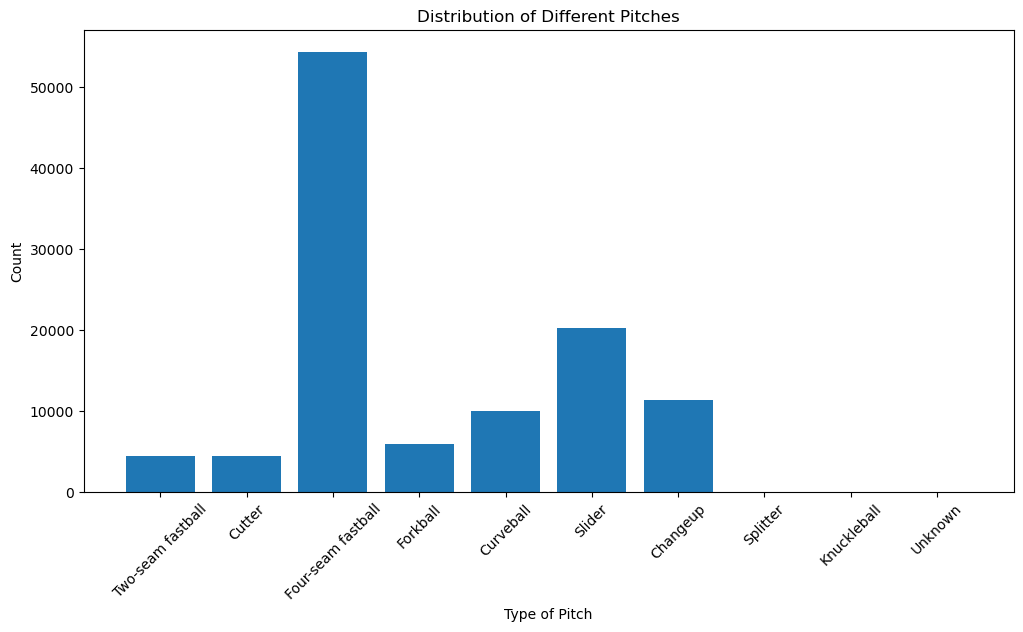

In [49]:
import matplotlib.pyplot as plt

# 假設 all_team 是一個 DataFrame，我們先提取第 227 行數據
data = all_team.loc[227]

# 排除非數值的列並翻譯列名
name_trans = {
    '二/伸': 'Two-seam fastball',
    '卡特': 'Cutter',
    '四縫': 'Four-seam fastball',
    '指叉': 'Forkball',
    '曲球': 'Curveball',
    '滑球': 'Slider',
    '變速': 'Changeup',
    '快指': 'Splitter',
    '蝴蝶': 'Knuckleball',
    '小便': 'Unknown'
}

categories_zh = data.index[3:]  # 排除 'Season', 'Team', 'Player'
values = data.values[3:]        # 排除對應的數值

# 翻譯列名
categories_en = categories_zh.map(name_trans)

# 繪製長條圖
plt.figure(figsize=(12, 6))
plt.bar(categories_en, values)

# 添加標籤和標題
plt.xlabel('Type of Pitch')
plt.ylabel('Count')
plt.title('Distribution of Different Pitches')

# 顯示圖表
plt.xticks(rotation=45)  # 如果標籤較長，將其旋轉以防重疊
plt.show()


統計完23,24賽季的中職投手最喜歡的球種前兩名分是四縫線速球和滑球。
所以找的打者也要比較會面對這兩個球種